# Park Power to the People
## UP 206a Final - Notebook 1 of 2
## Carolyn Chu

I'm working to answer the question, 'Where do we need parks most in Los Angeles?' I made an index to rank census tracts looking at different indicators using census data on income, race, and language spoken at home. I chose these based on research that specific groups -- including low-income people, Black and Latinx/Hispanic people, and people who cannot find culturally-appropriate programming -- have less access to parks and recreation services than their counterparts. Using these variables, I give each census tract a score 1-4 to determine park need. I then add them up so that each census tract has a score out of a possible 16 points.

At the beginning of this notebook, I'll bring in the park data so that I can add it to maps throughout.

This notebook is divided into the following sections:
1. Import Libraries, LA City Boundaries, and Parks Data
2. Building the Income Indicator
3. Building the Race Indicators, specifically Hispanic/Latinx and Black racial groups
4. Building the Language Spoken at Home Indicator
5. Putting the Indicator Scores Together
6. More with Parks Data

# 1. Import Libraries, LA City Boundaries, and Parks Data
I'll be using the city boundary and parks dataset throughout this notebook so I'll import those now.

In [1]:
# import libraries

import pandas as pd                      # for data wrangling
import geopandas as gpd                  # for analyzing spatial data
import contextily as ctx                 # for base maps
import matplotlib.pyplot as plt          # for plotting data
import numpy as np                       # for math and querying

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import LA City boundaries and project

city_bounds = gpd.read_file('data/City Boundary of Los Angeles.geojson')
city_boundary = city_bounds.to_crs(epsg=3857)

In [3]:
# add parks data

parks_unprojected = gpd.read_file("https://data.lacity.org/api/geospatial/rwq7-yhp5?method=export&format=GeoJSON")
parks = parks_unprojected.to_crs(epsg=3857)

# 2. Creating the Indicator for Median Household Income

I'm using Median Household Income data from the American Community Survey 5-Year Data Estimates (2015-2019). I pulled data from censusreporter.org. Maps and plots for this indicator will be colored in the orange family.

In [4]:
# import data
income = gpd.read_file('data/acs2019_5yr_medianincome.geojson')

### 2.1 Data Cleanup
Note: while putting this notebook together, I often ran codes such as .head(), .tail(), and .info() to make sure I was running appropriate code, though I removed many of these checks while cleaning up the notebook to keep things tidy. I just want to assure the reader that I checked often to make sure my data didn't look wonky!

In [5]:
income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             1005 non-null   object  
 1   name              1005 non-null   object  
 2   B19013001         993 non-null    float64 
 3   B19013001, Error  990 non-null    float64 
 4   geometry          1005 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 39.4+ KB


In [6]:
# drop the last row, which is for all of LA city
income = income.drop([1004])

#drop census tracts with no income data
income = income.dropna(subset=['B19013001'])

In [7]:
# rename the third and fourth column to Median Household Income and Margin of Error
# refer to metadata for any clarification needed

income.columns = ['geoid', 'name', 'Median Household Income', 'Margin of Error', 'geometry']

### 2.2 Descriptive Statistics

In [8]:
# get basic statistics
income['Median Household Income'].describe()

count       992.000000
mean      68203.515121
std       36642.300370
min        9191.000000
25%       42758.000000
50%       58398.500000
75%       85267.500000
max      250001.000000
Name: Median Household Income, dtype: float64

Text(0.5, 1.0, 'Distribution of Median Household Income by Census Tracts in LA')

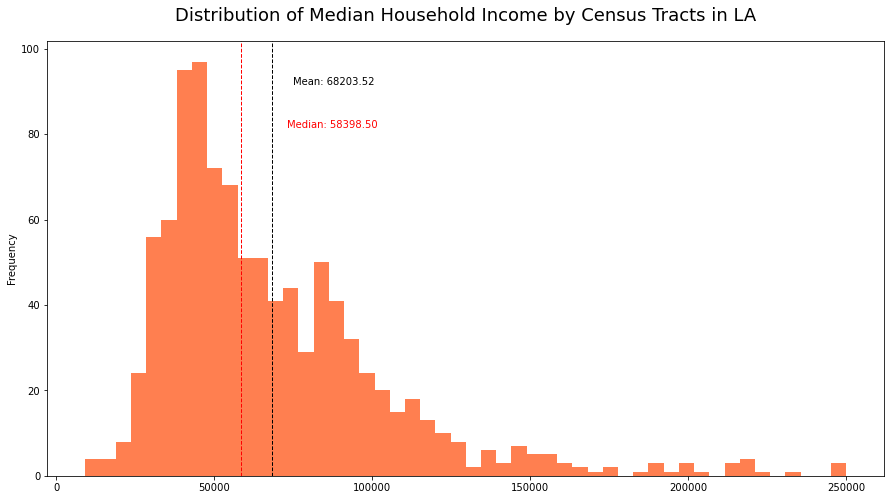

In [9]:
#plot as a histogram

income['Median Household Income'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='coral'
                                  )

#add mean and median lines
plt.axvline(income['Median Household Income'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(income['Median Household Income'].median(), color='r', linestyle='dashed', linewidth=1)

#add labels for mean and median
min_ylim, max_ylim = plt.ylim()
plt.text(income['Median Household Income'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(income['Median Household Income'].mean()))
plt.text(income['Median Household Income'].median()*1.25, max_ylim*0.8, 'Median: {:.2f}'.format(income['Median Household Income'].median()),color='r')
plt.title('Distribution of Median Household Income by Census Tracts in LA', fontsize=18, pad=20 )

### 2.3 Rank Census Tracts 1-4 Based on Median Household Income (MHI)
I'm classifying the census tracts by quartiles. They will receive a score of 1-4, with 1 representing highest MHI (and corresponding to less park need) and 4 representing lowest MHI (and therefore more park need).

In [10]:
# adding a column with conditions using numpy

# create a list of conditions
conditions = [
    (income['Median Household Income'] <= 42758.00),
    (income['Median Household Income'] > 42758.00) & (income['Median Household Income'] <= 58398.50),
    (income['Median Household Income'] > 58398.50) & (income['Median Household Income'] <= 85267.50),
    (income['Median Household Income'] > 85267.50)
]

# create a list of values we want to assign for each condition
values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
income ['MHI Indicator'] = np.select(conditions, values)

income.sample(5)

geoid                                   name  \
556  14000US06037208710  Census Tract 2087.10, Los Angeles, CA   
849  14000US06037265304  Census Tract 2653.04, Los Angeles, CA   
18   14000US06037104124  Census Tract 1041.24, Los Angeles, CA   
427  14000US06037191110  Census Tract 1911.10, Los Angeles, CA   
396  14000US06037188202  Census Tract 1882.02, Los Angeles, CA   

     Median Household Income  Margin of Error  \
556                  69656.0          14244.0   
849                  21228.0           3675.0   
18                   77885.0          13046.0   
427                  37700.0           4860.0   
396                 113267.0          20706.0   

                                              geometry MHI Indicator  
556  MULTIPOLYGON (((-118.28435 34.06833, -118.2843...             2  
849  MULTIPOLYGON (((-118.45311 34.07059, -118.4530...             4  
18   MULTIPOLYGON (((-118.39181 34.27762, -118.3916...             2  
427  MULTIPOLYGON (((-118.30924 34.09810, -118.3070...             4  
396  MULTIPOLYGON (((-118.28614 34.11850, -118.2845...             1

In [11]:
#reproject the dataframe to plot with layers and background
income = income.to_crs(epsg=3857)

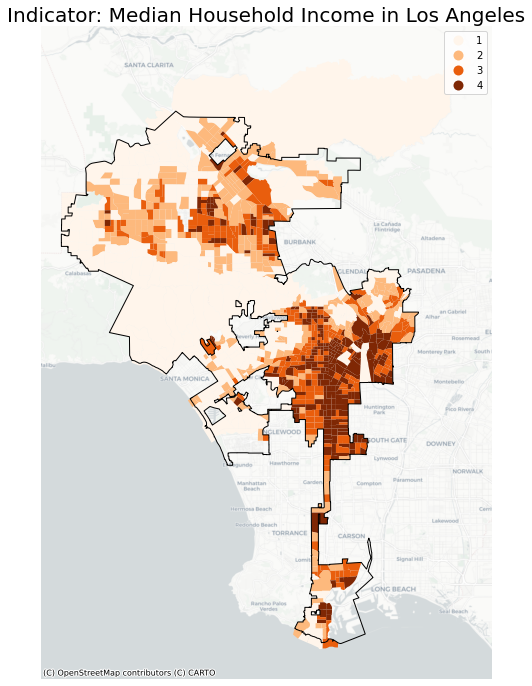

In [12]:
# map the indicator
fig, ax = plt.subplots(figsize=(12, 12))

income.plot(ax=ax,
            column='MHI Indicator',
            legend=True,
            cmap='Oranges'
           )

city_boundary.plot(ax=ax,
                facecolor="none",
                edgecolor="black")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Indicator: Median Household Income in Los Angeles',fontsize=20,pad=5)

# add a basemap
ctx.add_basemap (ax,source=ctx.providers.CartoDB.Positron)

### 2.4 Final Data Cleanup for this Indicator
I'm happy with the results so I'm going to do a bit of cleanup and create a new gdf with just the most essential information. I'm going to add the other indicators to this gdf toward the end of this notebook.

In [13]:
# list column names
income.columns.tolist()

['geoid',
 'name',
 'Median Household Income',
 'Margin of Error',
 'geometry',
 'MHI Indicator']

In [14]:
# decide which columns I want to keep

income_keepcolumns = ['geoid',
 'name',
 'geometry',
 'MHI Indicator']

# make a copy gdf of just those columns
inc = income[income_keepcolumns].copy()
inc.tail()

geoid                                   name  \
988  14000US06037930200     Census Tract 9302, Los Angeles, CA   
991  14000US06037980010  Census Tract 9800.10, Los Angeles, CA   
993  14000US06037980015  Census Tract 9800.15, Los Angeles, CA   
994  14000US06037980019  Census Tract 9800.19, Los Angeles, CA   
999  14000US06037980024  Census Tract 9800.24, Los Angeles, CA   

                                              geometry MHI Indicator  
988  MULTIPOLYGON (((-13192503.578 4075227.101, -13...             1  
991  MULTIPOLYGON (((-13163713.575 4039600.478, -13...             4  
993  MULTIPOLYGON (((-13170262.055 3997538.878, -13...             2  
994  MULTIPOLYGON (((-13202401.217 4038791.402, -13...             1  
999  MULTIPOLYGON (((-13193418.068 4053521.172, -13...             1

# 3. Creating the Indicators for Race (Hispanic/Latinx and Black/African American)

I'm using "Hispanic or Latino Origin by Race" data from the American Community Survey 5-Year Data Estimates (2015-2019). I pulled data from censusreporter.org. Maps and plots for the Hispanic/Latinx Indicator will be colored in greens and Black/African American will be in purples.

In [15]:
race_fulldata = gpd.read_file('data/acs2019_5yr_race.geojson')

### 3.1 Data Cleanup

In [16]:
# keep only necessary columns

race_trimmed_keepcolumns = ['geoid',
 'name',
 'B03002001',
 'B03002004',
 'B03002012',
 'geometry']

# create a copy gdf of just this subset

race_trimmed_unproj = race_fulldata[race_trimmed_keepcolumns].copy()

In [17]:
# project df
race_trimmed = race_trimmed_unproj.to_crs(epsg=3857)

In [18]:
#rename columns for clarity

race_trimmed.columns = ['geoid',
 'name',
 'Total',
 'Non Hispanic Black',
 'Hispanic',
 'geometry']

In [19]:
# normalize the data

race_trimmed['Percent Non Hispanic Black'] = race_trimmed['Non Hispanic Black']/race_trimmed['Total']*100
race_trimmed['Percent Hispanic'] = race_trimmed['Hispanic']/race_trimmed['Total']*100

In [20]:
# check the data
race_trimmed.tail(3)

geoid                                   name      Total  \
1002  14000US06037980031  Census Tract 9800.31, Los Angeles, CA     1175.0   
1003  14000US06037990200     Census Tract 9902, Los Angeles, CA        0.0   
1004      16000US0644000                        Los Angeles, CA  3966936.0   

      Non Hispanic Black   Hispanic  \
1002               232.0      387.0   
1003                 0.0        0.0   
1004            341750.0  1922409.0   

                                               geometry  \
1002  MULTIPOLYGON (((-13168099.229 3995788.284, -13...   
1003  MULTIPOLYGON (((-13206496.549 4033174.071, -13...   
1004  MULTIPOLYGON (((-13210080.926 4054325.107, -13...   

      Percent Non Hispanic Black  Percent Hispanic  
1002                   19.744681         32.936170  
1003                         NaN               NaN  
1004                    8.614961         48.460802

In [21]:
# drop la city row
race_trimmed = race_trimmed.drop([1004])

#drop NaN rows i.e. population = 0
race_trimmed = race_trimmed.dropna(subset=['Percent Non Hispanic Black', 'Percent Hispanic'])

### 3.2 Descriptive Statistics for Hispanic/Latinx Data

In [22]:
race_trimmed['Percent Hispanic'].describe()

count    999.000000
mean      47.709974
std       28.618584
min        0.000000
25%       20.043632
50%       48.353068
75%       72.132209
max      100.000000
Name: Percent Hispanic, dtype: float64

Text(0.5, 1.0, 'Distribution of Percent Hispanic/Latinx Population by Census Tracts')

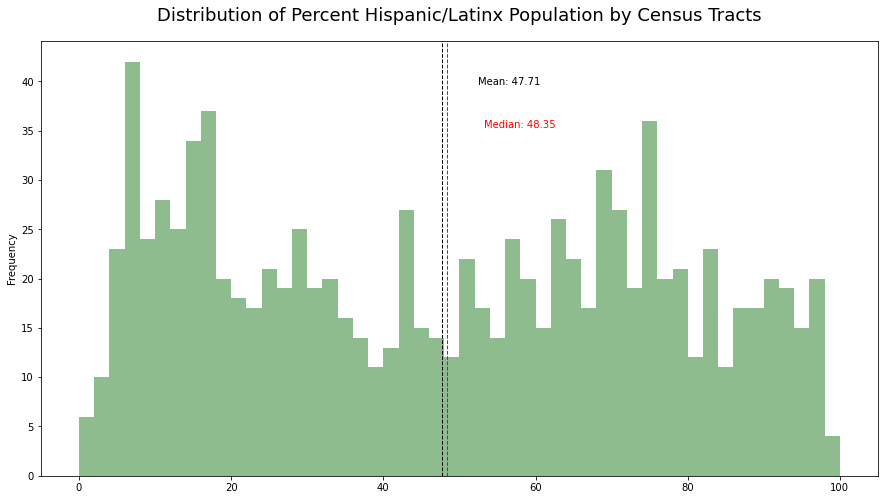

In [23]:
# histogram

race_trimmed['Percent Hispanic'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='darkseagreen'
                                  )

# add lines and text for the mean and median
plt.axvline(race_trimmed['Percent Hispanic'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(race_trimmed['Percent Hispanic'].median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(race_trimmed['Percent Hispanic'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(race_trimmed['Percent Hispanic'].mean()))
plt.text(race_trimmed['Percent Hispanic'].median()*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(race_trimmed['Percent Hispanic'].median()),color='r')

# add a title
plt.title('Distribution of Percent Hispanic/Latinx Population by Census Tracts', fontsize=18, pad=20)

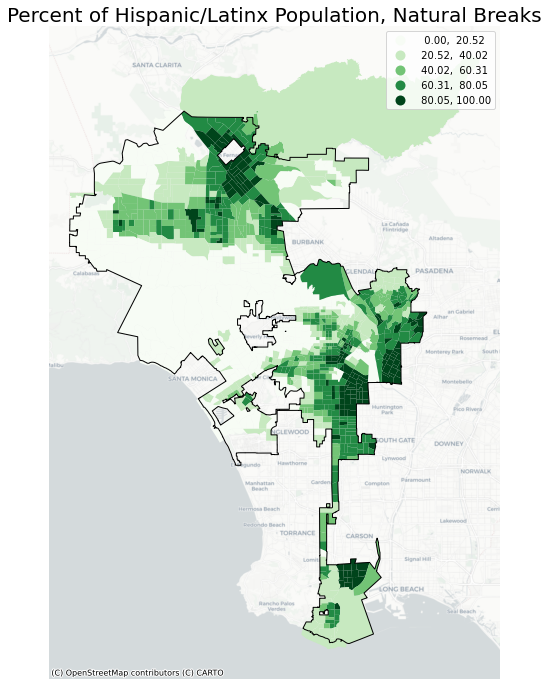

In [24]:
# plot using natural breaks to see how it compares to quantiles
fig, ax = plt.subplots(figsize=(12, 12))

race_trimmed.plot(ax=ax,
          column='Percent Hispanic',
          legend=True,
          scheme='naturalbreaks',
          cmap='Greens'
         )

city_boundary.plot(ax=ax,
                facecolor="none",
                edgecolor="black")

# turn off axes
ax.axis('off')

# add a title
ax.set_title('Percent of Hispanic/Latinx Population, Natural Breaks',fontsize=20,pad=5)

# add a basemap
ctx.add_basemap (ax,source=ctx.providers.CartoDB.Positron)

Using the information in the legend to understand Natural Breaks classification, it looks like the data were divided similarly to quantiles. I'm going to continue using quantiles for this indicator.

### 3.3 Rank Census Tracts 1-4 Based on Percentage of Hispanic/Latinx Population
Tracts given a score of 4 have a higher percentage of Hispanic/Latinx population and tracts given a score of 1 have a smaller percentage of Hispanic/Latinx population.

In [25]:
# add a column of indicators for Hispanic race data

# create a list of conditions
race_conditions = [
    (race_trimmed['Percent Hispanic'] >= 72.132209),
    (race_trimmed['Percent Hispanic'] < 72.132209) & (race_trimmed['Percent Hispanic'] >= 48.353068),
    (race_trimmed['Percent Hispanic'] < 48.353068) & (race_trimmed['Percent Hispanic'] >= 20.043632),
    (race_trimmed['Percent Hispanic'] < 20.043632)
]

# create a list of values we want to assign for each condition
race_values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
race_trimmed ['Hispanic Population Indicator'] = np.select(race_conditions, race_values)

race_trimmed.sample(3)

geoid                                   name   Total  \
582  14000US06037211310  Census Tract 2113.10, Los Angeles, CA  3873.0   
656  14000US06037218702  Census Tract 2187.02, Los Angeles, CA  2056.0   
78   14000US06037111202  Census Tract 1112.02, Los Angeles, CA  5169.0   

     Non Hispanic Black  Hispanic  \
582                96.0    2872.0   
656               808.0    1016.0   
78                102.0    1574.0   

                                              geometry  \
582  MULTIPOLYGON (((-13169138.508 4038576.374, -13...   
656  MULTIPOLYGON (((-13173722.867 4033195.698, -13...   
78   MULTIPOLYGON (((-13194462.801 4064450.766, -13...   

     Percent Non Hispanic Black  Percent Hispanic  \
582                    2.478699         74.154402   
656                   39.299611         49.416342   
78                     1.973302         30.450764   

    Hispanic Population Indicator  
582                             4  
656                             3  
78                              2

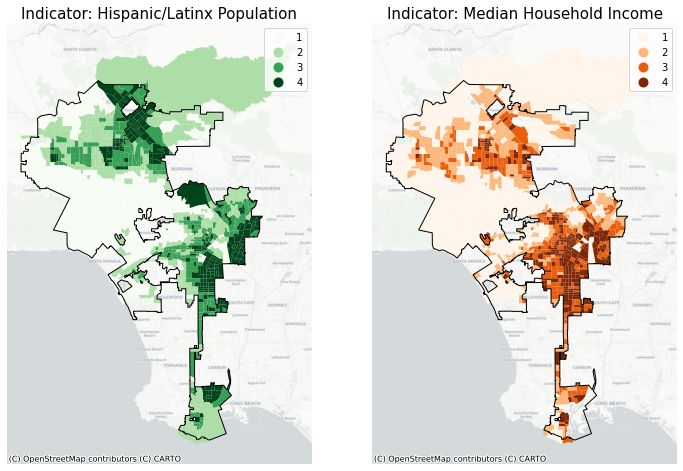

In [26]:
# map it, side by side with income indicator
# subplots, 1 row and 2 columns of plots

fig,ax = plt.subplots(1,2,figsize=(12,12))

# for the subplot on the left
race_trimmed.plot(ax=ax[0],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )
city_boundary.plot(ax=ax[0],
                facecolor="none",
                edgecolor="black")

ax[0].set_title('Indicator: Hispanic/Latinx Population', fontsize=15,pad=5)
ax[0].axis('off');           
ctx.add_basemap (ax=ax[0],source=ctx.providers.CartoDB.Positron)

# for the subplot on the right
inc.plot(ax=ax[1],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

city_boundary.plot(ax=ax[1],
                facecolor="none",
                edgecolor="black")

ax[1].set_title('Indicator: Median Household Income',fontsize=15,pad=5)
ax[1].axis('off')
ctx.add_basemap (ax=ax[1],source=ctx.providers.CartoDB.Positron)

I wanted to see these two side-by-side. There's definitely some overlap of the darkest colored census tracts (particularly in downtown and Northeast LA). There's some contrast in the San Fernando Valley region.

### 3.4 Descriptive Statistics for Black Population Data

In [27]:
race_trimmed['Percent Non Hispanic Black'].describe()

count    999.000000
mean       8.295381
std       11.891175
min        0.000000
25%        1.758696
50%        4.358740
75%        8.310453
max       82.157870
Name: Percent Non Hispanic Black, dtype: float64

Text(0.5, 1.0, 'Distribution of Percent Black Population by Census Tracts')

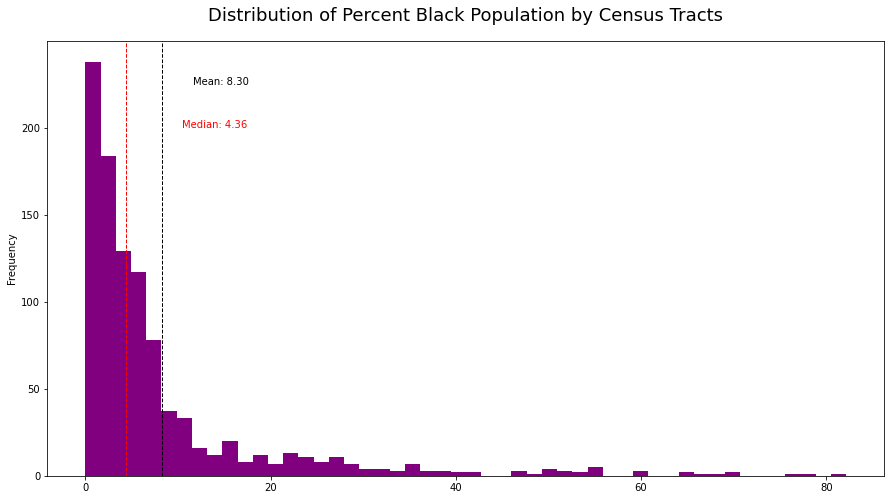

In [28]:
# histogram
race_trimmed['Percent Non Hispanic Black'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='purple'
                                  )

# add mean and median lines
plt.axvline(race_trimmed['Percent Non Hispanic Black'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(race_trimmed['Percent Non Hispanic Black'].median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(race_trimmed['Percent Non Hispanic Black'].mean()*1.4, max_ylim*0.9, 'Mean: {:.2f}'.format(race_trimmed['Percent Non Hispanic Black'].mean()))
plt.text(race_trimmed['Percent Non Hispanic Black'].median()*2.4, max_ylim*0.8, 'Median: {:.2f}'.format(race_trimmed['Percent Non Hispanic Black'].median()),color='r')
plt.title('Distribution of Percent Black Population by Census Tracts', fontsize=18, pad=20)

This data is very skewed! This hints at how racial segregation continues across Los Angeles.

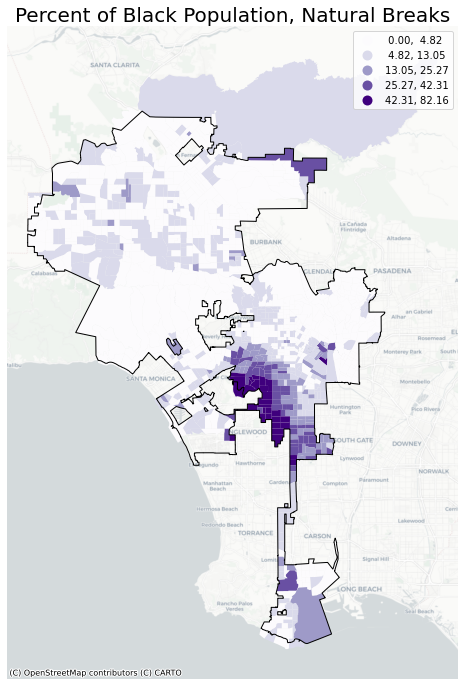

In [29]:
# plot using natural breaks to see how it compares to quantiles
fig, ax = plt.subplots(figsize=(12, 12))

race_trimmed.plot(ax=ax,
          column='Percent Non Hispanic Black',
          legend=True,
          scheme='naturalbreaks',
          cmap='Purples'
         )

city_boundary.plot(ax=ax,
                facecolor="none",
                edgecolor="black")

ax.set_title('Percent of Black Population, Natural Breaks',fontsize=20,pad=5)

# turn off axes
ax.axis('off')

# add a basemap
ctx.add_basemap (ax,source=ctx.providers.CartoDB.Positron)

### 3.5 Rank Census Tracts 1-4 Based on Percentage of Black Population
The Black LA population seems to be centered around South LA. I have decided not to use quantiles for this category, mostly because I feel like an equal spread of tracts in the 1-4 rankings wouldn't properly represent the segregation of neighborhoods. I'm using the mean and median as cutoffs for scores of 1 and 2, and I'm giving a score of 4 to tracts that are majority Black (i.e. population of Black residents at 50% or more).

In [30]:
#create indicator for Black race data

# create a list of conditions
black_conditions = [
    (race_trimmed['Percent Non Hispanic Black'] >= 50),
    (race_trimmed['Percent Non Hispanic Black'] < 50) & (race_trimmed['Percent Non Hispanic Black'] >= 8.310453),
    (race_trimmed['Percent Non Hispanic Black'] < 8.310453) & (race_trimmed['Percent Non Hispanic Black'] >= 4.36),
    (race_trimmed['Percent Non Hispanic Black'] < 4.36)
]

# create a list of values we want to assign for each condition
black_values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
race_trimmed['Black Population Indicator'] = np.select(black_conditions, black_values)

race_trimmed.sample(3)

geoid                                   name   Total  \
696  14000US06037224320  Census Tract 2243.20, Los Angeles, CA  2972.0   
935  14000US06037278001  Census Tract 2780.01, Los Angeles, CA  2508.0   
702  14000US06037226002  Census Tract 2260.02, Los Angeles, CA  1820.0   

     Non Hispanic Black  Hispanic  \
696               240.0    2490.0   
935               106.0     746.0   
702               208.0     793.0   

                                              geometry  \
696  MULTIPOLYGON (((-13167326.004 4034154.835, -13...   
935  MULTIPOLYGON (((-13182313.615 4023396.835, -13...   
702  MULTIPOLYGON (((-13164628.510 4033003.746, -13...   

     Percent Non Hispanic Black  Percent Hispanic  \
696                    8.075370         83.781965   
935                    4.226475         29.744817   
702                   11.428571         43.571429   

    Hispanic Population Indicator Black Population Indicator  
696                             4                          2  
935                             2                          1  
702                             2                          3

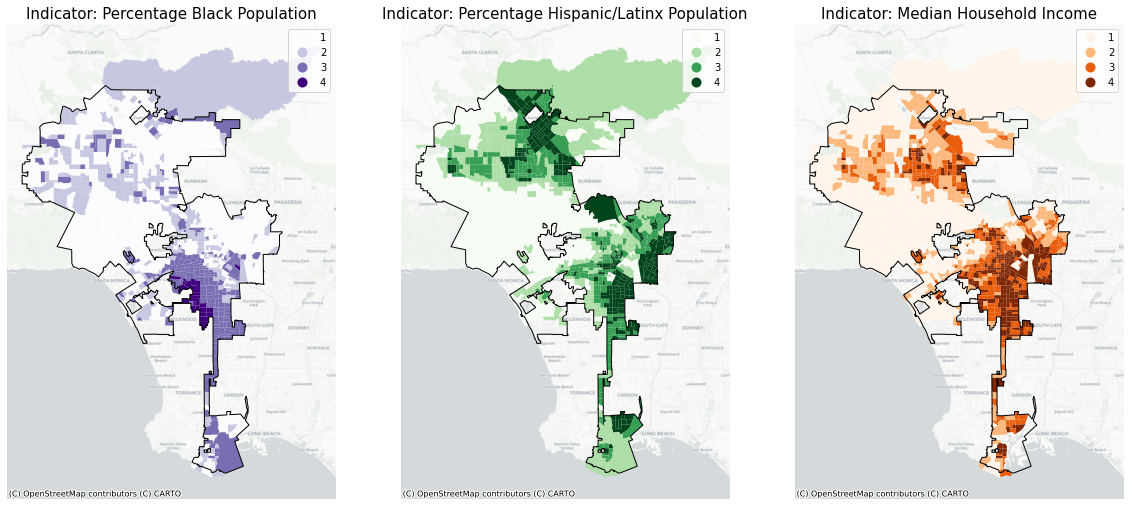

In [31]:
# subplots, 1 row and 3 columns of plots

fig,ax = plt.subplots(1,3,figsize=(20,20))

# for the first subplot
race_trimmed.plot(ax=ax[0],
         column='Black Population Indicator',
         legend=True,
         cmap='Purples'
        )

city_boundary.plot(ax=ax[0],
                facecolor="none",
                edgecolor="black")

ax[0].set_title('Indicator: Percentage Black Population',fontsize=15,pad=5)
ax[0].axis('off')
ctx.add_basemap (ax=ax[0],source=ctx.providers.CartoDB.Positron)

# for the subplot on the left
race_trimmed.plot(ax=ax[1],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )

city_boundary.plot(ax=ax[1],
                facecolor="none",
                edgecolor="black")

ax[1].set_title('Indicator: Percentage Hispanic/Latinx Population', fontsize=15,pad=5)
ax[1].axis('off');  
ctx.add_basemap (ax=ax[1],source=ctx.providers.CartoDB.Positron)

# for the subplot on the right
inc.plot(ax=ax[2],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

city_boundary.plot(ax=ax[2],
                facecolor="none",
                edgecolor="black")

ax[2].set_title('Indicator: Median Household Income',fontsize=15,pad=5)
ax[2].axis('off')
ctx.add_basemap (ax=ax[2],source=ctx.providers.CartoDB.Positron)

### 3.6 Final Data Cleaup for these 2 Race Indicators

In [32]:
race_trimmed.columns.tolist()

['geoid',
 'name',
 'Total',
 'Non Hispanic Black',
 'Hispanic',
 'geometry',
 'Percent Non Hispanic Black',
 'Percent Hispanic',
 'Hispanic Population Indicator',
 'Black Population Indicator']

In [33]:
# drop unnecessary columns, keep things mean and clean
# i dropped the geometry column because i'm going to join to the income gdf which already has a geometry column

race_keepcolumns = ['geoid',
 'Hispanic Population Indicator',
 'Black Population Indicator']

race = race_trimmed[race_keepcolumns].copy()

In [34]:
race.head(3)

geoid Hispanic Population Indicator Black Population Indicator
0  14000US06037101110                             2                          1
1  14000US06037101122                             1                          1
2  14000US06037101210                             2                          1

# 4. Creating an Indicator for Language Access
I'm using "Languages Spoken at Home for the Population 5 Years and Over" data from the American Community Survey 5-Year Data Estimates (2015-2019). I got the data from censusreporter.org. I'm going to clean the data to pull percentages of population that speak another language at home **and** speaks English less than "very well". Maps and plots for this indicator will be colored in blues.

I'm using this dataset as a proxy for language access. This [research article on park equity](https://www.tandfonline.com/doi/full/10.1080/13574809.2018.1497927?casa_token=az-pm4CevPUAAAAA%3AzUqXqLBskjZAqDWeEgSM8WypLPrR_hVWcvLfH3TMOKSoJLuPYxTnyo7o_LDzAWzFN4hJSJHE7IQtYRU) examines psychological barriers to park access, or the extent that a park appears safe, welcoming and available for different social groups. [Another study](https://www.sciencedirect.com/science/article/pii/S0016718511001813?casa_token=V3fDx6FTRtUAAAAA:xTVfavdRKgxQOI4KS17opeIMAhNV7mYwAbspCPxpeMAd_5POBrzpqVgpNsUSkQeDp7K7BnWZ4K65) finds that non-English speaking individuals have difficulty accessing parks and recreation services when parks lack information in multiple languages or bilingual staff.



In [35]:
# bring in language data from censusreporter
language_fulldata = gpd.read_file('data/acs2019_5yr_languagespokenathome.geojson')

### 4.1 Data Cleanup

In [36]:
language_fulldata.columns.tolist()

['geoid',
 'name',
 'C16001001',
 'C16001001, Error',
 'C16001002',
 'C16001002, Error',
 'C16001003',
 'C16001003, Error',
 'C16001004',
 'C16001004, Error',
 'C16001005',
 'C16001005, Error',
 'C16001006',
 'C16001006, Error',
 'C16001007',
 'C16001007, Error',
 'C16001008',
 'C16001008, Error',
 'C16001009',
 'C16001009, Error',
 'C16001010',
 'C16001010, Error',
 'C16001011',
 'C16001011, Error',
 'C16001012',
 'C16001012, Error',
 'C16001013',
 'C16001013, Error',
 'C16001014',
 'C16001014, Error',
 'C16001015',
 'C16001015, Error',
 'C16001016',
 'C16001016, Error',
 'C16001017',
 'C16001017, Error',
 'C16001018',
 'C16001018, Error',
 'C16001019',
 'C16001019, Error',
 'C16001020',
 'C16001020, Error',
 'C16001021',
 'C16001021, Error',
 'C16001022',
 'C16001022, Error',
 'C16001023',
 'C16001023, Error',
 'C16001024',
 'C16001024, Error',
 'C16001025',
 'C16001025, Error',
 'C16001026',
 'C16001026, Error',
 'C16001027',
 'C16001027, Error',
 'C16001028',
 'C16001028, Error',
 

In [37]:
languages_keepcolumns = ['geoid',
 'name',
 'C16001001', #total
 'C16001002', #onlyenglish
 'C16001005', #speaks spanish and english less than "very well"
 'C16001008', #french, haitian, cajun
 'C16001011', #german
 'C16001014', #russian, polish, slavic
 'C16001017', #Indo-european 
 'C16001020', #korean
 'C16001023', #chinese - mandarin and cantonese
 'C16001026', # vietnamese
 'C16001029', #tagalog
 'C16001032', #other asian languages
 'C16001035', # arabic
 'C16001038', #other languages
 'geometry']

language_trimmed_unproj = language_fulldata[languages_keepcolumns].copy()
language_trimmed_unproj.sample(3)

geoid                                   name  C16001001  \
556  14000US06037208710  Census Tract 2087.10, Los Angeles, CA     4615.0   
86   14000US06037113102  Census Tract 1131.02, Los Angeles, CA     2954.0   
458  14000US06037194300     Census Tract 1943, Los Angeles, CA     3146.0   

     C16001002  C16001005  C16001008  C16001011  C16001014  C16001017  \
556     1065.0      578.0        0.0        8.0        0.0        7.0   
86      2173.0       82.0        0.0        0.0        0.0       46.0   
458     2429.0       77.0       32.0        0.0       28.0        0.0   

     C16001020  C16001023  C16001026  C16001029  C16001032  C16001035  \
556      910.0       15.0       26.0       77.0       71.0        0.0   
86         0.0       26.0        0.0       25.0       17.0        0.0   
458        0.0        0.0        0.0        0.0        7.0        0.0   

     C16001038                                           geometry  
556       14.0  MULTIPOLYGON (((-118.28435 34.06833, -118.2843...  
86         0.0  MULTIPOLYGON (((-118.57984 34.27127, -118.5798...  
458       17.0  MULTIPOLYGON (((-118.39651 34.09618, -118.3958...

In [38]:
# project df
language_trimmed = language_trimmed_unproj.to_crs(epsg=3857)

In [39]:
#rename columns

language_trimmed.columns = ['geoid',
 'name',
 'Total',
 'Speak only English',
 'Speaks Spanish and English less than well',
 'Speaks French Haitian Cajun and English less than well',
 'Speaks German and English less than well',
 'Speaks Russian Polish Slavic and English less than well',
 'Speaks Indo European and English less than well',
 'Speaks Korean and English less than well',
 'Speaks Chinese and English less than well',
 'Speaks Vietnamese and English less than well',
 'Speaks Tagalog and English less than well',
 'Speaks Other Asian Languages and English less than well',
 'Speaks Arabic and English less than well',
 'Speaks Other Language and English less than well',
 'geometry']

In [40]:
# sum up the "speak english less than well" columns
language_trimmed['Total Speak English less than well'] = language_trimmed['Speaks Spanish and English less than well'] + language_trimmed['Speaks French Haitian Cajun and English less than well'] + language_trimmed['Speaks German and English less than well'] + language_trimmed['Speaks Russian Polish Slavic and English less than well'] + language_trimmed['Speaks Indo European and English less than well'] + language_trimmed['Speaks Korean and English less than well'] + language_trimmed['Speaks Chinese and English less than well'] + language_trimmed['Speaks Vietnamese and English less than well'] + language_trimmed['Speaks Tagalog and English less than well'] + language_trimmed['Speaks Other Asian Languages and English less than well'] + language_trimmed['Speaks Arabic and English less than well'] + language_trimmed['Speaks Other Language and English less than well']

In [41]:
#normalize the data
language_trimmed['Percent English less than well Speakers'] = language_trimmed['Total Speak English less than well']/language_trimmed['Total']*100
language_trimmed['Percent English Only Speakers'] = language_trimmed['Speak only English']/language_trimmed['Total']*100

In [42]:
language_trimmed.tail(3)

geoid                                   name      Total  \
1002  14000US06037980031  Census Tract 9800.31, Los Angeles, CA     1155.0   
1003  14000US06037990200     Census Tract 9902, Los Angeles, CA        0.0   
1004      16000US0644000                        Los Angeles, CA  3732673.0   

      Speak only English  Speaks Spanish and English less than well  \
1002               716.0                                      132.0   
1003                 0.0                                        0.0   
1004           1533183.0                                   699084.0   

      Speaks French Haitian Cajun and English less than well  \
1002                                                0.0        
1003                                                0.0        
1004                                             3531.0        

      Speaks German and English less than well  \
1002                                       0.0   
1003                                       0.0   
1004                                    1080.0   

      Speaks Russian Polish Slavic and English less than well  \
1002                                                0.0         
1003                                                0.0         
1004                                            17048.0         

      Speaks Indo European and English less than well  \
1002                                              0.0   
1003                                              0.0   
1004                                          66923.0   

      Speaks Korean and English less than well  \
1002                                       0.0   
1003                                       0.0   
1004                                   57207.0   

      Speaks Chinese and English less than well  \
1002                                        0.0   
1003                                        0.0   
1004                                    30625.0   

      Speaks Vietnamese and English less than well  \
1002                                           0.0   
1003                                           0.0   
1004                                       10079.0   

      Speaks Tagalog and English less than well  \
1002                                        0.0   
1003                                        0.0   
1004                                    27418.0   

      Speaks Other Asian Languages and English less than well  \
1002                                                0.0         
1003                                                0.0         
1004                                            23899.0         

      Speaks Arabic and English less than well  \
1002                                       0.0   
1003                                       0.0   
1004                                    5791.0   

      Speaks Other Language and English less than well  \
1002                                              26.0   
1003                                               0.0   
1004                                            7975.0   

                                               geometry  \
1002  MULTIPOLYGON (((-13168099.229 3995788.284, -13...   
1003  MULTIPOLYGON (((-13206496.549 4033174.071, -13...   
1004  MULTIPOLYGON (((-13210080.926 4054325.107, -13...   

      Total Speak English less than well  \
1002                               158.0   
1003                                 0.0   
1004                            950660.0   

      Percent English less than well Speakers  Percent English Only Speakers  
1002                                13.679654                      61.991342  
1003                                      NaN                            NaN  
1004                                25.468612                      41.074667

In [43]:
# drop the LA city row
language_trimmed = language_trimmed.drop([1004])

#drop NaN rows i.e. population = 0
language_trimmed = language_trimmed.dropna(subset=['Percent English less than well Speakers', 'Percent English Only Speakers'])

### 4.2 Descriptive Statistics for Language Data

In [44]:
language_trimmed['Percent English less than well Speakers'].describe()

count    999.000000
mean      25.471426
std       14.928414
min        0.000000
25%       12.624330
50%       25.577437
75%       36.481506
max       70.171615
Name: Percent English less than well Speakers, dtype: float64

Text(0.5, 1.0, 'Distribution of Census Tracts and Percent Population That Speaks English Less than Well')

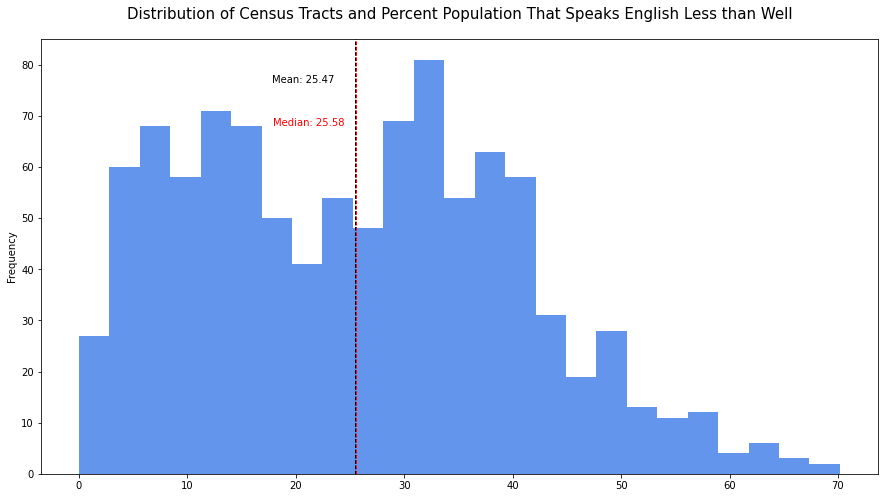

In [45]:
#histogram

language_trimmed['Percent English less than well Speakers'].plot.hist(figsize=(15,8),
                                           bins=25,
                                           color='cornflowerblue'
                                  )

# mark and label mean and median
plt.axvline(language_trimmed['Percent English less than well Speakers'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(language_trimmed['Percent English less than well Speakers'].median(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(language_trimmed['Percent English less than well Speakers'].mean()*0.7, max_ylim*0.9, 'Mean: {:.2f}'.format(language_trimmed['Percent English less than well Speakers'].mean()))
plt.text(language_trimmed['Percent English less than well Speakers'].median()*0.7, max_ylim*0.8, 'Median: {:.2f}'.format(language_trimmed['Percent English less than well Speakers'].median()),color='r')

plt.title('Distribution of Census Tracts and Percent Population That Speaks English Less than Well', fontsize=15,pad=20)

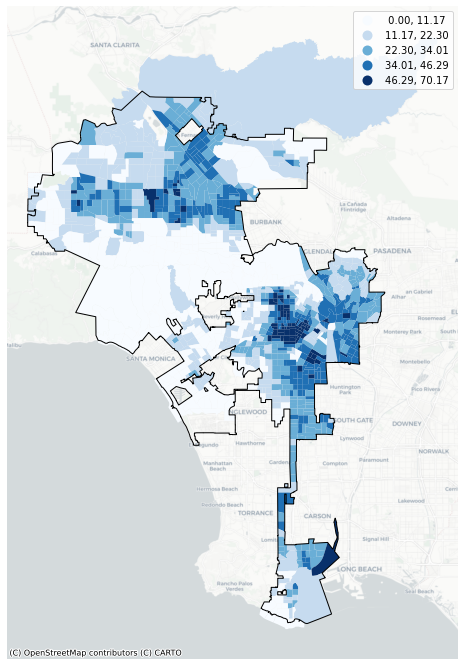

In [46]:
# using matplotlib, visualize the data
# plot using natural breaks to see how it compares to quantiles
fig, ax = plt.subplots(figsize=(12, 12))

language_trimmed.plot(ax=ax,
                 column='Percent English less than well Speakers',
                 legend=True, 
                 scheme='naturalbreaks',
                 cmap='Blues'
          )

city_boundary.plot(ax=ax,
                facecolor="none",
                edgecolor="black")

# turn off axes
ax.axis('off')

# add a basemap
ctx.add_basemap (ax,source=ctx.providers.CartoDB.Positron)

Looking at the histogram and choropleth map, I think a mix of quantiles and that natural break at the 46% are good divisions for this data and indicators.
### 4.3 Rank Census Tracts 1-4 Based on Percentage of People Who Said They Speak English Less Than "Very Well"

In [47]:
lang_conditions = [
    (language_trimmed['Percent English less than well Speakers'] <= 12.624330),
    (language_trimmed['Percent English less than well Speakers'] > 12.624330) & (language_trimmed['Percent English less than well Speakers'] <= 25.577437),
    (language_trimmed['Percent English less than well Speakers'] >= 25.577437) & (language_trimmed['Percent English less than well Speakers'] <= 46.290000),
    (language_trimmed['Percent English less than well Speakers'] > 46.290000)
]

# create a list of values we want to assign for each condition
lang_values = ['1', '2', '3', '4']

# create a new column and use np.select to assign values to it using our lists as arguments
language_trimmed['Language Access Indicator'] = np.select(lang_conditions, lang_values)

language_trimmed.head()

geoid                                   name   Total  \
0  14000US06037101110  Census Tract 1011.10, Los Angeles, CA  4000.0   
1  14000US06037101122  Census Tract 1011.22, Los Angeles, CA  3327.0   
2  14000US06037101210  Census Tract 1012.10, Los Angeles, CA  5925.0   
3  14000US06037101220  Census Tract 1012.20, Los Angeles, CA  3564.0   
4  14000US06037101300     Census Tract 1013, Los Angeles, CA  3795.0   

   Speak only English  Speaks Spanish and English less than well  \
0              2085.0                                      334.0   
1              2172.0                                        0.0   
2              1581.0                                      933.0   
3              1246.0                                      378.0   
4              1837.0                                       38.0   

   Speaks French Haitian Cajun and English less than well  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Speaks German and English less than well  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Speaks Russian Polish Slavic and English less than well  \
0                                               28.0         
1                                                0.0         
2                                                0.0         
3                                               27.0         
4                                                0.0         

   Speaks Indo European and English less than well  \
0                                            296.0   
1                                            221.0   
2                                            981.0   
3                                            597.0   
4                                            581.0   

   Speaks Korean and English less than well  ...  \
0                                      22.0  ...   
1                                     100.0  ...   
2                                     123.0  ...   
3                                      65.0  ...   
4                                      85.0  ...   

   Speaks Vietnamese and English less than well  \
0                                           0.0   
1                                           0.0   
2                                          34.0   
3                                           0.0   
4                                           0.0   

   Speaks Tagalog and English less than well  \
0                                       68.0   
1                                       19.0   
2                                        0.0   
3                                       17.0   
4                                        9.0   

   Speaks Other Asian Languages and English less than well  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                               12.0         
4                                                0.0         

   Speaks Arabic and English less than well  \
0                                       0.0   
1                                       0.0   
2                                      30.0   
3                                      11.0   
4                                       0.0   

   Speaks Other Language and English less than well  \
0                                              12.0   
1                                               0.0   
2                                               0.0   
3                                        

### 4.4 Final Data Cleanup for This Indicator

In [48]:
lang_newkeepcolumns = ['geoid',
 'Language Access Indicator']

language = language_trimmed[lang_newkeepcolumns].copy()

In [49]:
language.sample(3)

geoid Language Access Indicator
993  14000US06037980015                         2
959  14000US06037294520                         3
152  14000US06037121020                         3

Look at all four indicators together. I'm going to rearrange the order differently than they were listed out above.

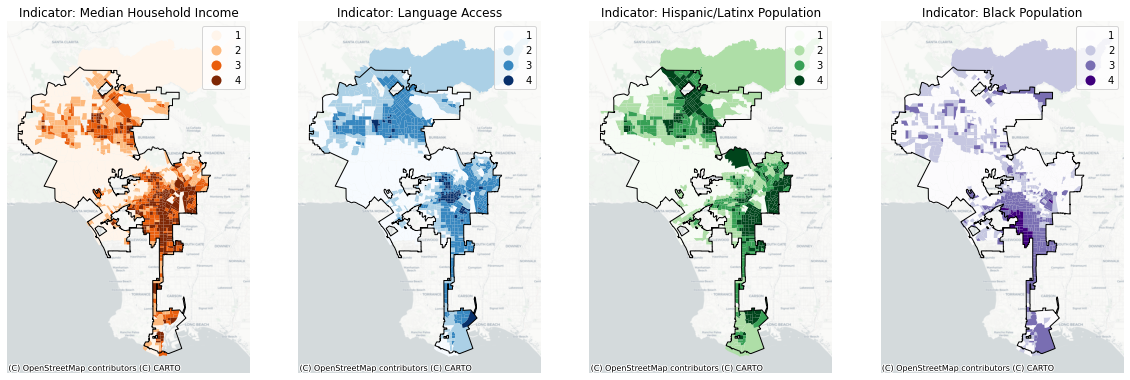

In [50]:
# subplots, 1 rows and 4 columns of plots

fig,ax = plt.subplots(1,4,figsize=(20,20))

# for the first subplot
inc.plot(ax=ax[0],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

city_boundary.plot(ax=ax[0],
                facecolor="none",
                edgecolor="black")

ax[0].set_title('Indicator: Median Household Income',fontsize=12,pad=5)
ax[0].axis('off')
ctx.add_basemap (ax=ax[0],source=ctx.providers.CartoDB.Positron)

# for the second subplot
language_trimmed.plot(ax=ax[1],
         column='Language Access Indicator',
         legend=True,
         cmap='Blues'
        )

city_boundary.plot(ax=ax[1],
                facecolor="none",
                edgecolor="black")

ax[1].set_title('Indicator: Language Access',fontsize=12,pad=5)
ax[1].axis('off')
ctx.add_basemap (ax=ax[1],source=ctx.providers.CartoDB.Positron)

# for the third subplot
race_trimmed.plot(ax=ax[2],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )

city_boundary.plot(ax=ax[2],
                facecolor="none",
                edgecolor="black")

ax[2].set_title('Indicator: Hispanic/Latinx Population', fontsize=12,pad=5)
ax[2].axis('off');           
ctx.add_basemap (ax=ax[2],source=ctx.providers.CartoDB.Positron)

# for the fourth subplot
race_trimmed.plot(ax=ax[3],
         column='Black Population Indicator',
         legend=True,
         cmap='Purples'
        )

city_boundary.plot(ax=ax[3],
                facecolor="none",
                edgecolor="black")

ax[3].set_title('Indicator: Black Population',fontsize=12,pad=5)
ax[3].axis('off')
ctx.add_basemap (ax=ax[3],source=ctx.providers.CartoDB.Positron)

# 5. Combine Scores for All Indicators
I'm going to combine the 4 gdf's that I created in sections 2-4. Census Tracts can have a minimum score of 4 to a maximum score of 16.

### 5.1. Attribute Join and Convert Datatypes

In [51]:
# join by attribute
indicators_firstjoin = inc.merge(race, on='geoid')
indicators = indicators_firstjoin.merge(language, on='geoid')

In [52]:
indicators.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   geoid                          992 non-null    object  
 1   name                           992 non-null    object  
 2   geometry                       992 non-null    geometry
 3   MHI Indicator                  992 non-null    object  
 4   Hispanic Population Indicator  992 non-null    object  
 5   Black Population Indicator     992 non-null    object  
 6   Language Access Indicator      992 non-null    object  
dtypes: geometry(1), object(6)
memory usage: 62.0+ KB


In [53]:
indicators.sample(3)

geoid                                   name  \
609  14000US06037212610  Census Tract 2126.10, Los Angeles, CA   
519  14000US06037204300     Census Tract 2043, Los Angeles, CA   
409  14000US06037189902  Census Tract 1899.02, Los Angeles, CA   

                                              geometry MHI Indicator  \
609  MULTIPOLYGON (((-13171263.374 4036689.012, -13...             3   
519  MULTIPOLYGON (((-13159493.787 4033832.293, -13...             4   
409  MULTIPOLYGON (((-13175098.442 4041972.668, -13...             2   

    Hispanic Population Indicator Black Population Indicator  \
609                             2                          1   
519                             4                          1   
409                             1                          1   

    Language Access Indicator  
609                         4  
519                         3  
409                         2

In [54]:
#need to change objects into integers
indicators['MHI Indicator']=indicators['MHI Indicator'].astype(str).astype(int)
indicators['Hispanic Population Indicator']=indicators['Hispanic Population Indicator'].astype(str).astype(int)
indicators['Black Population Indicator']=indicators['Black Population Indicator'].astype(str).astype(int)
indicators['Language Access Indicator']=indicators['Language Access Indicator'].astype(str).astype(int)

In [55]:
# check
indicators.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   geoid                          992 non-null    object  
 1   name                           992 non-null    object  
 2   geometry                       992 non-null    geometry
 3   MHI Indicator                  992 non-null    int64   
 4   Hispanic Population Indicator  992 non-null    int64   
 5   Black Population Indicator     992 non-null    int64   
 6   Language Access Indicator      992 non-null    int64   
dtypes: geometry(1), int64(4), object(2)
memory usage: 62.0+ KB


In [56]:
# sum up the indicator scores for a total score
indicators['Total Indicator Score'] = indicators['MHI Indicator'] + indicators['Hispanic Population Indicator'] + indicators['Black Population Indicator'] + indicators['Language Access Indicator']

In [57]:
indicators.sample(3)

geoid                                   name  \
306  14000US06037137301  Census Tract 1373.01, Los Angeles, CA   
3    14000US06037101220  Census Tract 1012.20, Los Angeles, CA   
143  14000US06037120103  Census Tract 1201.03, Los Angeles, CA   

                                              geometry  MHI Indicator  \
306  MULTIPOLYGON (((-13207313.857 4052077.623, -13...              1   
3    MULTIPOLYGON (((-13167528.939 4062726.771, -13...              3   
143  MULTIPOLYGON (((-13186188.757 4059493.238, -13...              4   

     Hispanic Population Indicator  Black Population Indicator  \
306                              1                           1   
3                                2                           1   
143                              4                           1   

     Language Access Indicator  Total Indicator Score  
306                          1                      4  
3                            3                      9  
143                          4                     13

### 5.2 Project Geodataframes and Layer with LA Neighborhoods

In [58]:
# neighborhood data from LA Times
nh = gpd.read_file("https://s3-us-west-2.amazonaws.com/mappingla.com/downloads/neighborhoods/la_city.json")

In [59]:
nh.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      114 non-null    object  
 1   slug      114 non-null    object  
 2   geometry  114 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.8+ KB


In [60]:
# reproject dataframes
indicators_mercator = indicators.to_crs(epsg=3857)
nh_mercator = nh.to_crs(epsg=3857)

### 5.3 First Map of All Combined Data
First map the park need index now that all indicators have been added together. I'll add on parks data too.

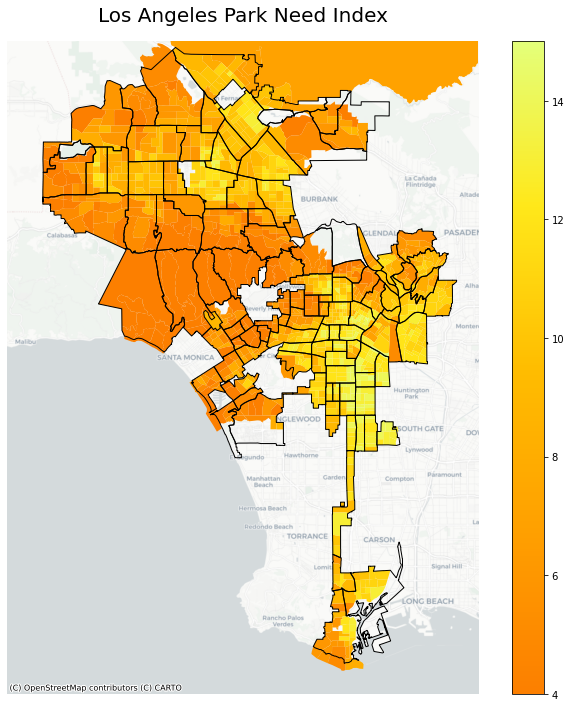

In [61]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index',fontsize=20,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

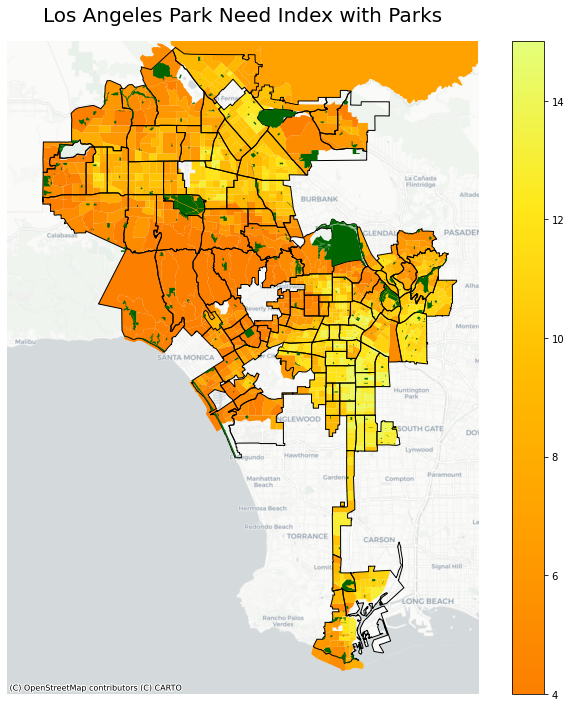

In [62]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

parks.plot(ax=ax,
           color="darkgreen",
           alpha=1
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index with Parks',fontsize=20,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

### 5.4 Add layer that highlights tracts with highest need

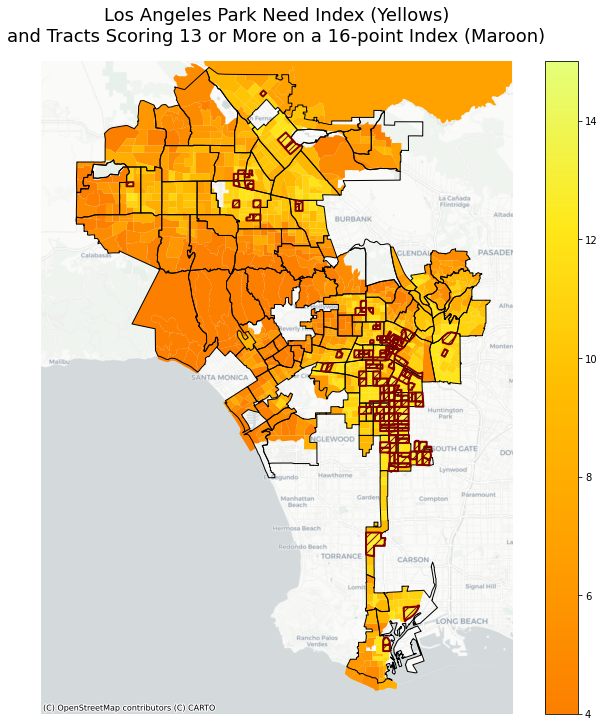

In [63]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )
indicators_mercator[indicators_mercator['Total Indicator Score'] >=13].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='maroon'
        )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index (Yellows)\n' + 'and Tracts Scoring 13 or More on a 16-point Index (Maroon)',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

### 5.5 Focus in on South LA

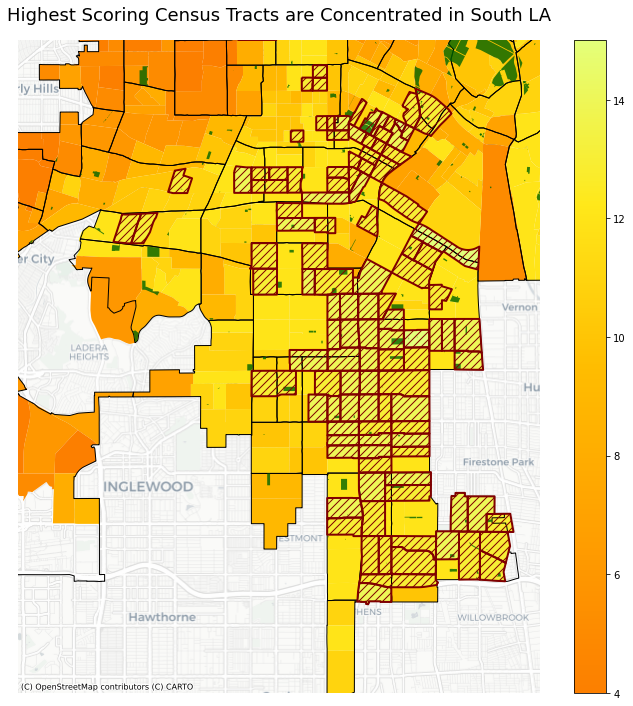

In [64]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

indicators_mercator[indicators_mercator['Total Indicator Score'] >=13].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='maroon'
        )

parks.plot(ax=ax,
           color="darkgreen",
           alpha=0.8
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4015000, 4040000])
ax.set_xlim([-13180000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

# 5.6 Let's try something else: Average Scores Per Neighborhood
I'm very pleased with the maps above, but I think it would be more effective if I showed score by neighborhood rather than census tract. So I'm going to take the average of each census tract by spatially joining census tracts to neighborhoods and using groupby to calculate averages.

In [65]:
# join the indicator data with neighborhood data
indicator_nh_join = gpd.sjoin(nh_mercator, indicators_mercator) #Spatial join
indicator_nh_join.head()

name_left             slug  \
0   Adams-Normandie  adams-normandie   
31  Exposition Park  exposition-park   
51   Jefferson Park   jefferson-park   
0   Adams-Normandie  adams-normandie   
51   Jefferson Park   jefferson-park   

                                             geometry  index_right  \
0   MULTIPOLYGON (((-13170098.527 4033826.516, -13...          685   
31  MULTIPOLYGON (((-13169697.777 4032255.042, -13...          685   
51  MULTIPOLYGON (((-13170098.527 4033692.182, -13...          685   
0   MULTIPOLYGON (((-13170098.527 4033826.516, -13...          676   
51  MULTIPOLYGON (((-13170098.527 4033692.182, -13...          676   

                 geoid                             name_right  MHI Indicator  \
0   14000US06037222001  Census Tract 2220.01, Los Angeles, CA              2   
31  14000US06037222001  Census Tract 2220.01, Los Angeles, CA              2   
51  14000US06037222001  Census Tract 2220.01, Los Angeles, CA              2   
0   14000US06037221401  Census Tract 2214.01, Los Angeles, CA              4   
51  14000US06037221401  Census Tract 2214.01, Los Angeles, CA              4   

    Hispanic Population Indicator  Black Population Indicator  \
0                               3                           3   
31                              3                           3   
51                              3                           3   
0                               2                           3   
51                              2                           3   

    Language Access Indicator  Total Indicator Score  
0                           2                     10  
31                          2                     10  
51                          2                     10  
0                           3                     12  
51                          3                     12

In [66]:
indicator_nh_join.shape

(1786, 11)

In [67]:
# average the score per neighborhood
mean_indicator = indicator_nh_join.groupby(['slug']).mean('Total Indicator Score').reset_index()
mean_indicator.tail()

slug  index_right  MHI Indicator  \
109        westwood   856.526316       1.842105   
110      wilmington   959.600000       2.750000   
111  windsor-square   528.800000       1.600000   
112        winnetka   242.052632       2.000000   
113  woodland-hills   305.125000       1.250000   

     Hispanic Population Indicator  Black Population Indicator  \
109                       1.052632                    1.263158   
110                       3.500000                    1.450000   
111                       1.400000                    1.600000   
112                       2.368421                    1.578947   
113                       1.125000                    1.666667   

     Language Access Indicator  Total Indicator Score  
109                   1.263158               5.421053  
110                   2.650000              10.350000  
111                   2.000000               6.600000  
112                   2.526316               8.473684  
113                   1.458333               5.500000

In [68]:
# list column names
mean_indicator.columns.tolist()

['slug',
 'index_right',
 'MHI Indicator',
 'Hispanic Population Indicator',
 'Black Population Indicator',
 'Language Access Indicator',
 'Total Indicator Score']

In [69]:
# decide which columns I want to keep
meanscore_keepcolumns = ['slug', 'Total Indicator Score']

# make a copy gdf of just those columns
meanscore = mean_indicator[meanscore_keepcolumns].copy()
meanscore.sample(5)

slug  Total Indicator Score
82   sepulveda-basin               6.222222
65  mount-washington               7.900000
99    vermont-knolls              12.800000
14   central-alameda              12.625000
75     playa-del-rey               4.857143

In [70]:
# join by attribute - reattach to the geometry
nh_indicatorscore = nh.merge(meanscore, on='slug')
nh_indicatorscore.sample(5)

name            slug  \
16      Chatsworth      chatsworth   
53     Lake Balboa     lake-balboa   
51  Jefferson Park  jefferson-park   
12     Canoga Park     canoga-park   
47       Hollywood       hollywood   

                                             geometry  Total Indicator Score  
16  MULTIPOLYGON (((-118.58509 34.30348, -118.5800...               6.272727  
53  MULTIPOLYGON (((-118.50092 34.22090, -118.5010...               8.166667  
51  MULTIPOLYGON (((-118.30901 34.03641, -118.3091...              11.416667  
12  MULTIPOLYGON (((-118.60302 34.23531, -118.6017...               8.952381  
47  MULTIPOLYGON (((-118.32691 34.10521, -118.3264...               8.814815

In [71]:
# project dataframe
nh_indicator = nh_indicatorscore.to_crs(epsg=3857)

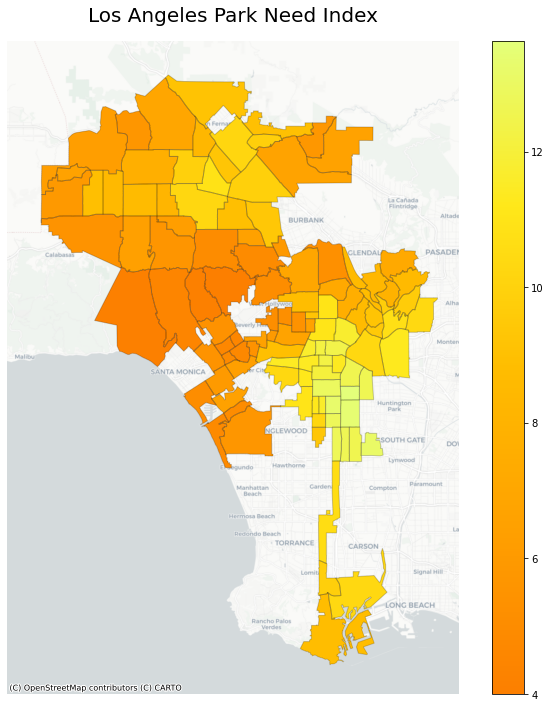

In [72]:
# map the neighborhoods
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index',fontsize=20,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

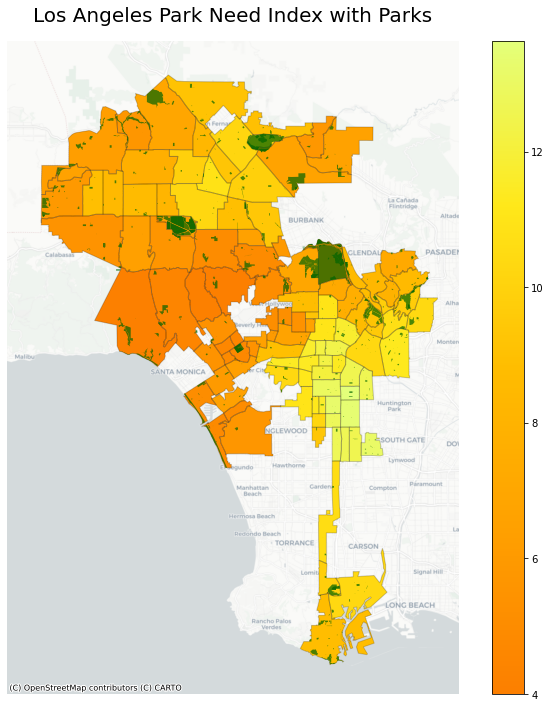

In [73]:
# map the neighborhoods
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )

parks.plot(ax=ax,
           color="darkgreen",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index with Parks',fontsize=20,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

In [74]:
# get basic stats
nh_indicator['Total Indicator Score'].describe()

count    114.000000
mean       8.497900
std        2.709085
min        4.000000
25%        6.000000
50%        8.690476
75%       10.679412
max       13.625000
Name: Total Indicator Score, dtype: float64

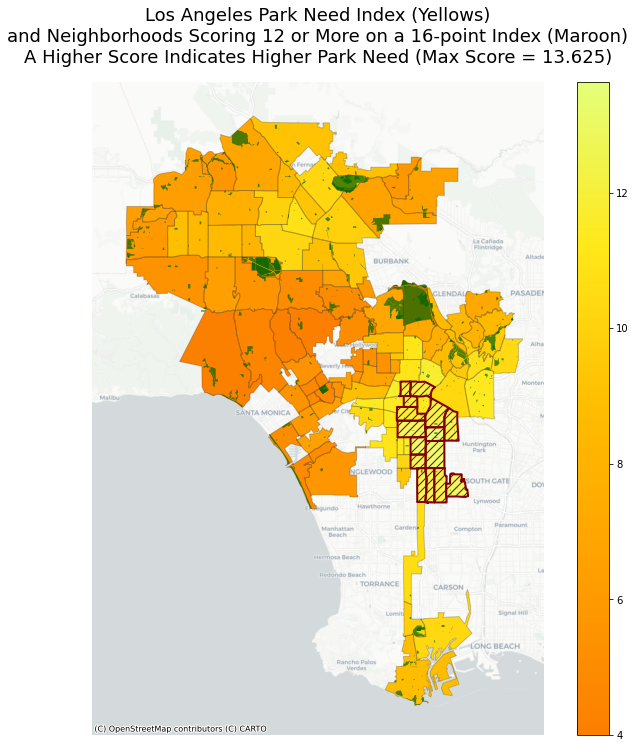

In [75]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )
nh_indicator[nh_indicator['Total Indicator Score'] >=12].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='maroon'
        )

parks.plot(ax=ax,
           color="darkgreen",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index (Yellows)\n' + 'and Neighborhoods Scoring 12 or More on a 16-point Index (Maroon)\n' + 'A Higher Score Indicates Higher Park Need (Max Score = 13.625)',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

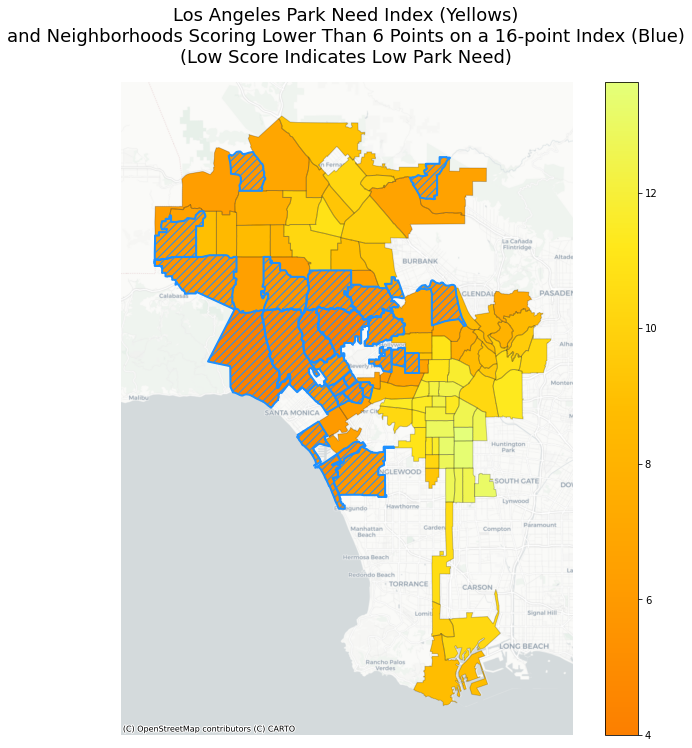

In [76]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )
nh_indicator[nh_indicator['Total Indicator Score'] <6].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='dodgerblue'
        )

#parks.plot(ax=ax,
 #          color="darkgreen",
  #         alpha=0.7
   #                )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index (Yellows)\n' + 'and Neighborhoods Scoring Lower Than 6 Points on a 16-point Index (Blue)\n' + '(Low Score Indicates Low Park Need)',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

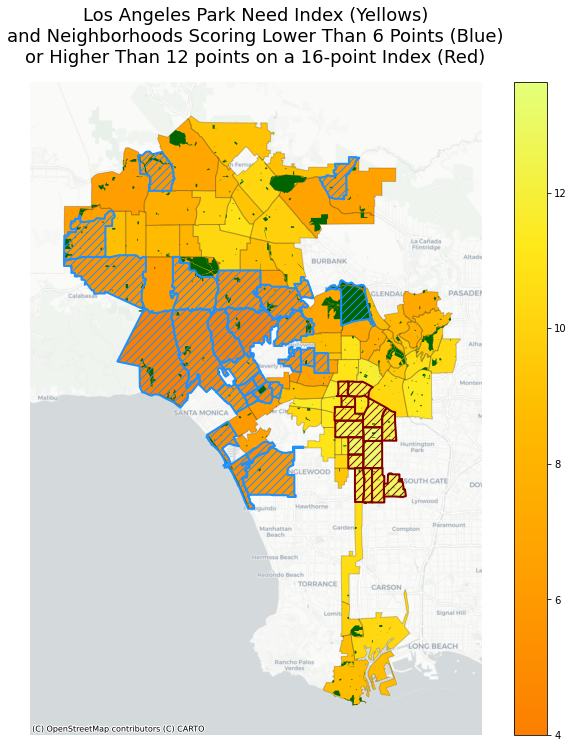

In [77]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )
nh_indicator[nh_indicator['Total Indicator Score'] <6].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='dodgerblue'
        )

nh_indicator[nh_indicator['Total Indicator Score'] >=12].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='maroon'
        )

parks.plot(ax=ax,
           color="darkgreen"
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])
# set a title
ax.set_title('Los Angeles Park Need Index (Yellows)\n' + 'and Neighborhoods Scoring Lower Than 6 Points (Blue)\n' + 'or Higher Than 12 points on a 16-point Index (Red)',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

One without parks data, which I think is easier to see!

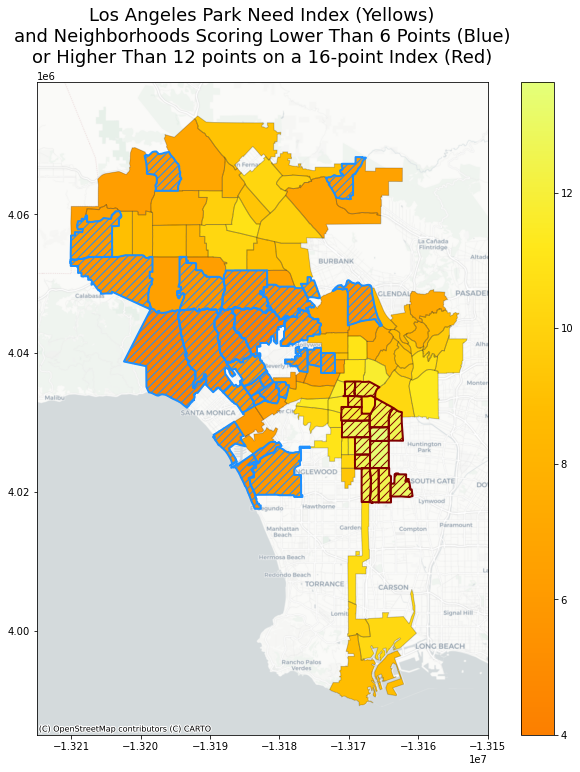

In [78]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r'
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )

nh_indicator[nh_indicator['Total Indicator Score'] <6].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='dodgerblue'
        )

nh_indicator[nh_indicator['Total Indicator Score'] >=12].boundary.plot(ax=ax,
        alpha=1,
        linewidth=2,
        hatch="///",
        color='maroon'
        )

# turn the axis off but set custom axes
#ax.axis('off')
ax.set_ylim([3985000, 4079000])
ax.set_xlim([-13215000, -13150000])
# set a title
ax.set_title('Los Angeles Park Need Index (Yellows)\n' + 'and Neighborhoods Scoring Lower Than 6 Points (Blue)\n' + 'or Higher Than 12 points on a 16-point Index (Red)',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

# 6. More with Parks Data!

In [79]:
parks.head(2)

name     shape_area objectid park_id  \
0  Robert F Kennedy Inspiration Memorial Park  6501.37488025        1    1056   
1                         Sycamore Grove Park  691462.199493        2     736   

                          name_alpha    shape_leng      area_acres issubpark  \
0  ROBERT F KENNEDY PARK (LAUSD) JUA  641.47054538  0.149251627315         N   
1                SYCAMORE GROVE PARK  6227.3991903   15.8738513625         N   

  region                         address  \
0      M  3400 W Wilshire Blvd, LA 90010   
1      M    4702 N Figueroa St, LA 90042   

                                          name_publi park_class cd_real  \
0  Kennedy (Robert F) Inspiration Memorial Park (...          N      10   
1                                Sycamore Grove Park          C      01   

                                            geometry  
0  MULTIPOLYGON (((-13168868.269 4037078.847, -13...  
1  MULTIPOLYGON (((-13158086.069 4042417.355, -13...

### 6.1 South LA zoom in

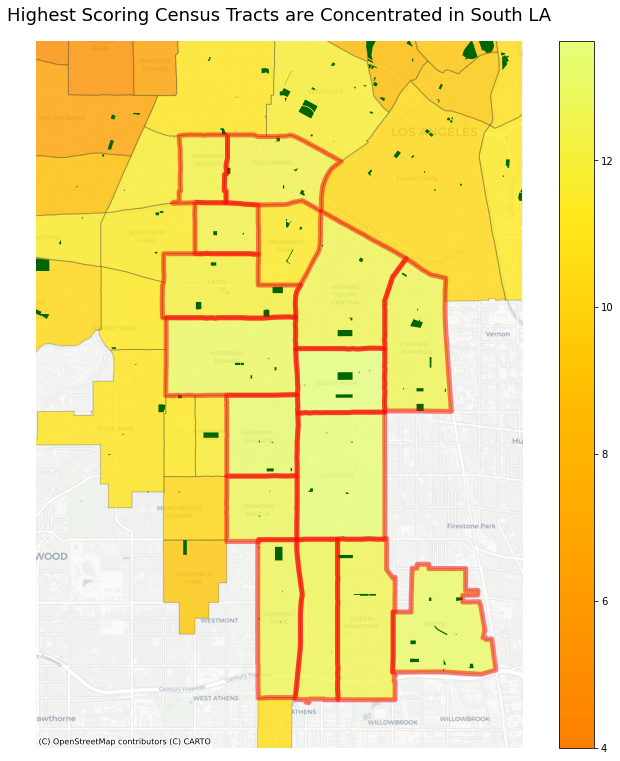

In [80]:
fig, ax = plt.subplots(figsize=(13,13))

# add the layer with ax=ax in the argument 
nh_indicator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='Wistia_r',
                  alpha=0.8
        )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black",
                 alpha=0.2
                )

nh_indicator[nh_indicator['Total Indicator Score'] >=12].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=5,
        color='red'
        )

parks.plot(ax=ax,
           color="darkgreen"
          )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4017000, 4038800])
ax.set_xlim([-13175000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

ctx.add_basemap (ax=ax,source=ctx.providers.CartoDB.Positron)

### 6.2 Adding a 1/2 mile buffer
I wanted to learn how to make a buffer. I ultimately decided not to include this in the storymap or presentation because I think it inaccurately shows park access. It shows more quantity rather than quality or size of parks. Also, it's just too much material to cover in an 8 minute presentation!

In [81]:
# half mile buffer
#half a mile is 804.672 meters

parks['buffer'] = parks.buffer(804.672)

In [82]:
parksbuffer = parks.set_geometry("buffer")

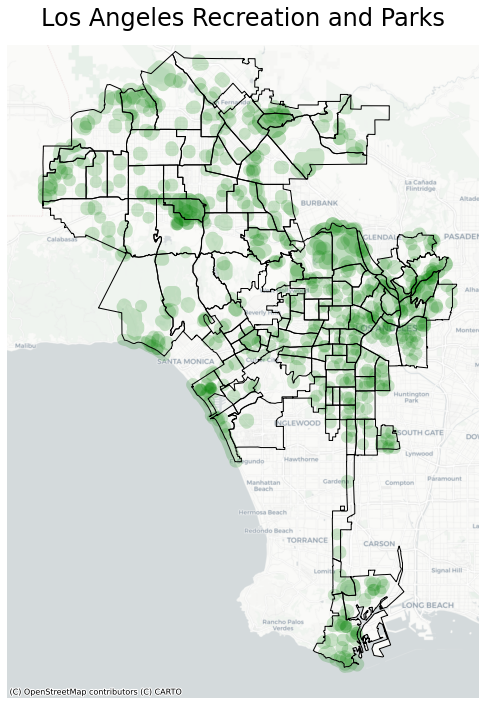

In [83]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
parksbuffer.plot(ax=ax,
                    color="green",
                 alpha=0.2
                   )

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Recreation and Parks',fontsize=24,pad=20)

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

### 6.3 Zoom in more!

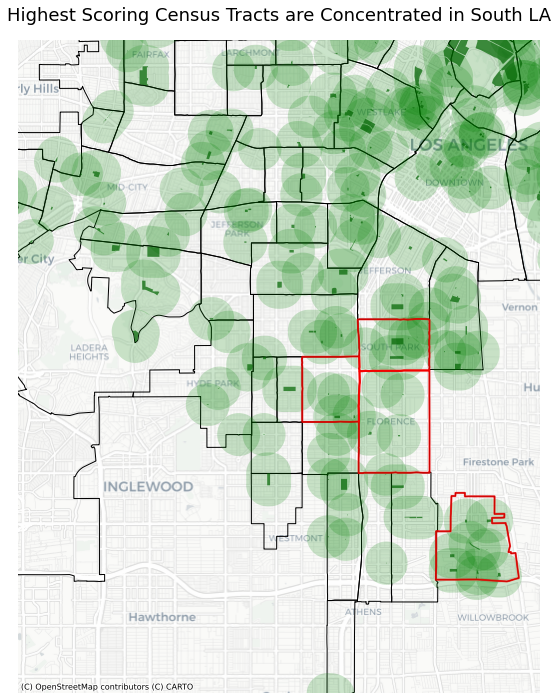

In [84]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

parksbuffer.plot(ax=ax,
                 color="green",
                 alpha=0.2
                )

nh_indicator[nh_indicator['Total Indicator Score'] >=13].boundary.plot(ax=ax,
        alpha=0.8,
        linewidth=2,
        color='red'
        )

parks.plot(ax=ax,
                    color="darkgreen",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4015000, 4040000])
ax.set_xlim([-13180000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

### 6.4 Even more!

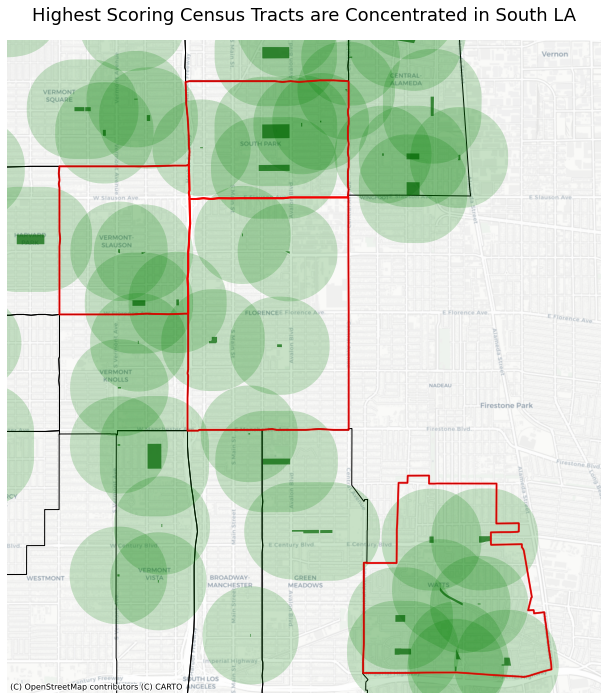

In [85]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

nh_indicator[nh_indicator['Total Indicator Score'] >=13].boundary.plot(ax=ax,
        alpha=0.8,
        linewidth=2,
        color='red'
        )

parksbuffer.plot(ax=ax,
                    color="green",
                 alpha=0.2
                   )
parks.plot(ax=ax,
                    color="darkgreen",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4019000, 4030000])
ax.set_xlim([-13170000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)